In [37]:
import librosa
import random
import torch
import torch.utils.data
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from librosa.filters import mel as librosa_mel_fn


In [38]:
gen_istft_n_fft= 16
gen_istft_hop_size= 4
segment_size= 8192
num_mels= 80
n_fft= 1024
hop_size= 256
win_size= 1024
sampling_rate= 16000
fmin= 0
fmax= 8000

In [39]:
def load_wav(full_path, sr):
    # sampling_rate, data = read(full_path)
    data, sampling_rate = librosa.load(full_path, sr)
    data = 0.95 * librosa.util.normalize(data)
    return data, sampling_rate

In [40]:
full_path = "/home/maxime/Documents/Code/Neural_Network/Pytorch/iSTFTNet-unofficial/data/VCTK/wavs/p314_195_mic2.flac"
sr = 16000
data, sampling_rate = load_wav(full_path, sr)

In [41]:
data.shape[0] / sampling_rate
time = np.linspace(0,data.shape[0] / sampling_rate, data.shape[0])

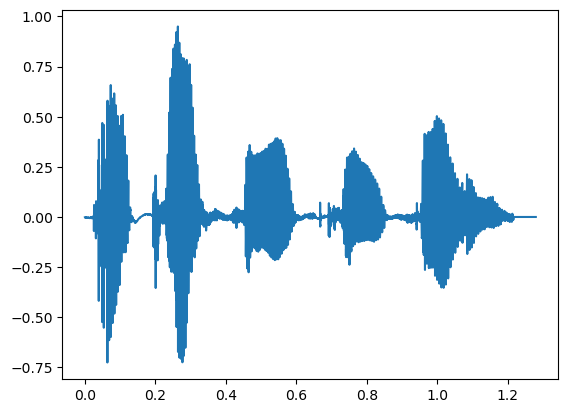

In [42]:
plt.plot(time,data)

In [43]:
audio = data
audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)
max_audio_start = audio.size(1) - segment_size
audio_start = random.randint(0, max_audio_start)
audio = audio[:, audio_start : audio_start + segment_size]

In [44]:
time_segment = np.linspace(audio_start / sampling_rate, audio_start / sampling_rate + segment_size / sampling_rate, segment_size )

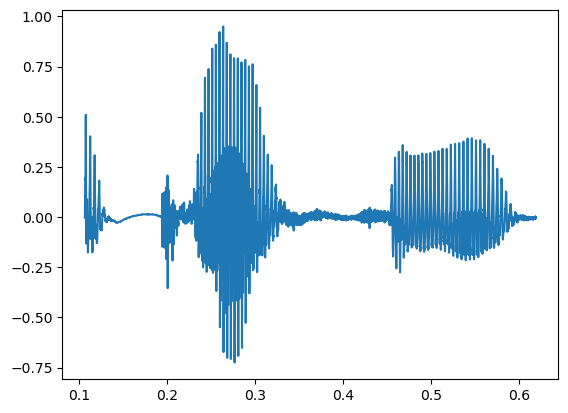

In [45]:
plt.plot(time_segment,audio[0])

In [46]:
def spectral_normalize_torch(magnitudes):
    # dynamic_range_compression
    output = torch.log(torch.clamp(magnitudes, min=1e-5) * 1)
    return output

In [54]:
def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax):
    """
    Args:
        y - wave
        n_fft
        num_mels - The number of mel frequency bin
        sampling_rate - Wave sampling rate
        hop_size
        win_size
        fmin - Minimum frequency
        fmax - Maximum frequency
    """
    center = False

    # if torch.min(y) < -1.0:
    #     print("min value is ", torch.min(y))
    # if torch.max(y) > 1.0:
    #     print("max value is ", torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(
            sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax
        )
        mel_basis[str(fmax) + "_" + str(y.device)] = (
            torch.from_numpy(mel).float().to(y.device)
        )
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(
        y.unsqueeze(1),
        (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)),
        mode="reflect",
    )
    y = y.squeeze(1)

    spec = torch.stft(
        y,
        n_fft,
        hop_length=hop_size,
        win_length=win_size,
        window=hann_window[str(y.device)],
        center=center,
        pad_mode="reflect",
        normalized=False,
        onesided=True,
        return_complex=False,
    )

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))

    spec = torch.matmul(mel_basis[str(fmax) + "_" + str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec, y

In [60]:
mel_basis = {}
hann_window = {}
mel, y = mel_spectrogram(
                audio,
                n_fft,
                num_mels,
                sampling_rate,
                hop_size,
                win_size,
                fmin,
                fmax,
            )
print(y.shape)
print(mel.shape)
print(mel_basis)
print(hann_window)

torch.Size([1, 8960])
torch.Size([1, 80, 32])
{'8000_cpu': tensor([[-0.0000, 0.0113, 0.0225,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0004, 0.0002, 0.0000]])}
{'cpu': tensor([0.0000e+00, 9.4175e-06, 3.7640e-05,  ..., 8.4698e-05, 3.7640e-05,
        9.4175e-06])}


torch.Size([1, 513, 32, 2])


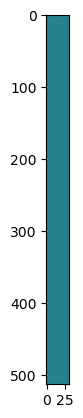

In [72]:
spec = torch.stft(
        y,
        n_fft,
        hop_length=hop_size,
        win_length=win_size,
        window=hann_window[str(y.device)],
        center=False,
        pad_mode="reflect",
        normalized=False,
        onesided=True,
        return_complex=False,
    )
print(spec.shape)
plt.imshow(spec[0,:,:,0])

torch.Size([1, 513, 32])


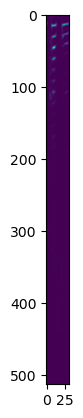

In [73]:
spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))
print(spec.shape)
plt.imshow(spec[0,:,:])

torch.Size([1, 80, 32])


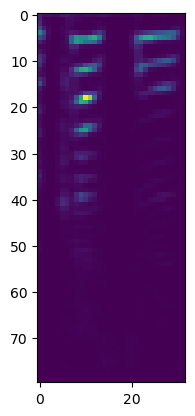

In [74]:
spec = torch.matmul(mel_basis[str(fmax) + "_" + str(y.device)], spec)
print(spec.shape)
plt.imshow(spec[0,:,:])

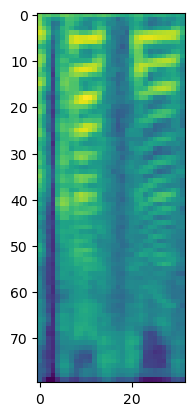

In [75]:
spec = spectral_normalize_torch(spec)
plt.imshow(spec[0,:,:])

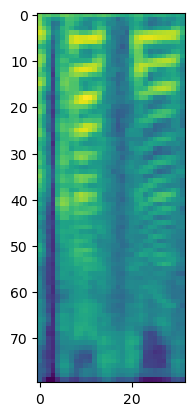

In [52]:
plt.imshow(mel[0])